In [165]:
"""
Elbow detection:

I run my kmeans for several k and track the mean of the mean square errors of the
clusters from their centroid. I divide the mse of every point (from their
collective centroid) by the "mean cluster mse" and when that value exceeds the
mean cluster mse, this is an elbow.

As an intuition, the ratio of errors equaling the cluster error
is some sort of equilibrium. I do not know why it seems to work
as well as it does. I came to this method by plotting several
functions of the MSEs against the MSE and noticing that when
those two functions crossed, there was reliably an elbow. At least
for the test dataset.
"""

'\nElbow detection:\n\nI run my kmeans for several k and track the mean of the mean square errors of the\nclusters from their centroid. I divide the mse of every point (from their\ncollective centroid) by the "mean cluster mse" and when that value exceeds the\nmean cluster mse, this is an elbow.\n\nAs an intuition, the ratio of errors equaling the cluster error\nis some sort of equilibrium. I do not know why it seems to work\nas well as it does. I came to this method by plotting several\nfunctions of the MSEs against the MSE and noticing that when\nthose two functions crossed, there was reliably an elbow. At least\nfor the test dataset.\n'

In [158]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

rng = np.random.default_rng()
def uniform_vec(low, high, count):
    """Generate count uniformly distributed vectors with each component i ranging between low[i] and high[i]"""
    o = np.empty((count, *low.shape))
    for vix in range(count):
        for ix in range(len(low)):
            o[vix][ix] = rng.uniform(low[ix], high[ix])
    return o
d = np.loadtxt("data.txt")

In [189]:
class kMeans:
    def __init__(self, data, nclust):
        self.nclust = nclust
        self.pts = data
        self.lub = np.minimum.reduce(data)
        self.glb = np.maximum.reduce(data)
        self.centroid_map = np.empty(len(data), dtype=int)
        self.centroids = uniform_vec(self.lub,self.glb,nclust)
        self.old_centroids = np.zeros_like(self.centroids)
        self.colors = mpl.colormaps['Set1'].resampled(nclust)
        self.assign_to_nearest_centroids()
        self.i = 0
        
    def assign_to_nearest_centroids(self):
        sqdist = lambda x: np.dot(x,x)
        for p_idx in range(len(self.pts)):
            # using the squared distance saves a sqrt operation inside this loop
            # the comparison result is the same either way.
            dists = [sqdist(self.pts[p_idx]-c) for c in self.centroids]
            self.centroid_map[p_idx] = np.argmin(dists)

    def recompute_centroids(self):
        # accumulate into centroids the sum of each cluster, finally
        # divide by the discovered population counts

        self.old_centroids = np.copy(self.centroids)
        self.centroids = np.zeros_like(self.centroids)
        centroid_cts = np.zeros(self.nclust,dtype=np.uint32)
        
        for ix in range(len(self.pts)):
            assg = self.centroid_map[ix]
            self.centroids[assg] += self.pts[ix]
            centroid_cts[assg] += 1

        for cl in range(self.nclust):
            if centroid_cts[cl] != 0:
                self.centroids[cl] /= centroid_cts[cl]

    def step(self):
        self.i += 1
        self.recompute_centroids()
        self.assign_to_nearest_centroids()

    def attempt_convergence(self, iters):
        """Run step to convergence, defined as a step changing the centroid delta by less than 2%"""
        self.iters = iters
        for _ in range(iters):
            centroid_change_before = np.sum(np.linalg.norm(self.old_centroids - self.centroids))
            self.step()
            centroid_change_here = np.sum(np.linalg.norm(self.old_centroids - self.centroids))
            if centroid_change_here / centroid_change_before < 0.02:
                print('converged after step:', self.i)
                break
            
    def debugstep(self):
        fig, p = plt.subplots(num=self.i+1,clear=True)
        self.step()
        self.plot(p)

    def debugconverge(self,iters):
        self.iters = iters
        for _ in range(iters):
            self.debugstep()
            centroid_change_here = np.sum(np.linalg.norm(self.old_centroids - self.centroids))
            if centroid_change_here < 1:
                print('converged after step:', self.i)
                break
        plt.close()

    def plot(self,plt):
        self.plot_points(plt)
        self.plot_centroids(plt)
    
    def clusters(self):
        clusts = [[] for _ in range(self.nclust)]
        for ix in range(len(self.pts)):
            clusts[self.centroid_map[ix]].append(self.pts[ix])
        return [np.array(c) for c in clusts]

    def plot_points(self, plt):
        clusts = self.clusters()
        for cl in range(self.nclust):
            if len(clusts[cl] > 0):
                plt.scatter(clusts[cl][:,0], clusts[cl][:,1], color=self.colors(cl))
                
    def plot_raw_points(self, plt):
        plt.scatter(self.pts[:,0], self.pts[:,1], color='grey')
    
    def plot_centroids(self,plt):
        plt.scatter(self.centroids[:,0], self.centroids[:,1], marker="s",edgecolors='black',color=[self.colors(i) for i in range(self.nclust)])
        plt.scatter(self.old_centroids[:,0], self.old_centroids[:,1], marker="s",edgecolors='purple',color=[self.colors(i) for i in range(self.nclust)])

    def mse(self):
        mses = []
        clusts = self.clusters()
        for cl in range(self.nclust):
            mses.append(np.mean((clusts[cl] - np.full_like(clusts[cl], self.centroids[cl]))**2))
        return np.mean(mses)

    def total_mse(self):
        return np.mean ((self.pts - np.full_like(self.pts, np.mean(self.pts)))**2)

def elbow(pts):
    k = 1
    kms = []
    inflection_pt = None
    endpt = 20
    while k <= endpt:
        km = kMeans(pts, k)
        km.attempt_convergence(100)
        kms.append((km, km.mse()))
        if inflection_pt is None and km.total_mse()/km.mse() > km.mse():
            inflection_pt = k
            endpt += 1
        k += 1
    
    return inflection_pt+1, kms

def plot_elbow(best_k, kms):
    _, p = plt.subplots(num=1)
    p.set_title("MSE vs k")
    vars = [k[1] for k in kms]
    p.plot(range(len(kms)), vars, color='blue')
    p.axvline(best_k)
    p.axhline(vars[best_k])
    p.plot(range(len(vars)), [kms[i][0].total_mse()/vars[i]  for i in range(len(vars))], color='red')
    
def kmeans_fall2022(pts, nclust):
    km = kMeans(pts, nclust)
    _, p = plt.subplots(num=1)
    p.set_title("Raw Points (initial randomized centroids)")
    km.plot_raw_points(p)
    km.plot_centroids(p)
    _,p2 = plt.subplots(num=2)
    p2.set_title("Final Clustering")
    km.attempt_convergence(200)
    km.plot_points(p2)
    km.plot_centroids(p2)

In [185]:
kidx, elbs = elbow(d)

converged after step: 2
converged after step: 3
converged after step: 5
converged after step: 13
converged after step: 19
converged after step: 12
converged after step: 14
converged after step: 32
converged after step: 28
converged after step: 22
converged after step: 20
converged after step: 18
converged after step: 16
converged after step: 26
converged after step: 30
converged after step: 29
converged after step: 29
converged after step: 33
converged after step: 58
converged after step: 43
converged after step: 44


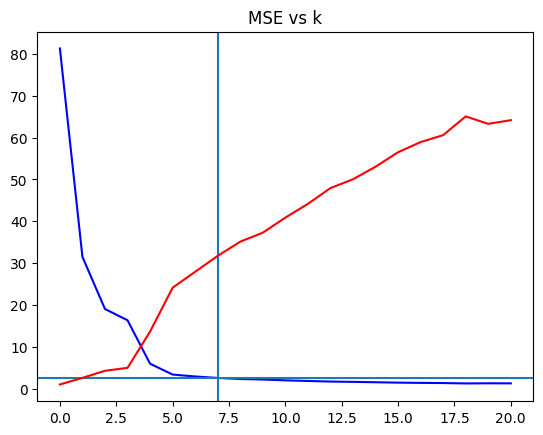

In [190]:
k = elbs[kidx][0].nclust
plot_elbow(k,elbs)

In [191]:
k

7

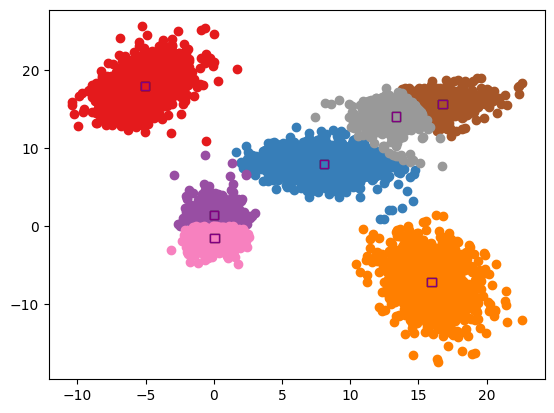

In [192]:
elbs[kidx][0].plot(plt.subplots()[1])